Below we handle imports and set font size for widgets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io.wavfile as wavfile

from pathlib import Path
import IPython.display as ipd
import ipywidgets as widgets

In [2]:
from IPython.display import display, HTML

display(HTML("""
<style>
    .widget-label { 
        font-size: 24px !important;
    }
    .slider-value { 
        font-size: 24px !important;
    }
    .widget-hslider .widget-readout {
        font-size: 22px !important;
    }
</style>
"""))


Intialize where your wav file exists on your system

In [3]:
wav_filename = 'ship_small.wav'
wav_file_path = Path(f'{Path.home()}/Downloads/{wav_filename}')
assert(wav_file_path.exists())

Be able to play the WAV file!

In [4]:
ipd.Audio(wav_file_path)

Read in the WAV file to plot time series!

In [5]:
sample_rate, audio_data = wavfile.read(wav_file_path)
audio_duration = audio_data.shape[0]/sample_rate
print(f'Reading in audio that is {audio_duration:.2f}s long with sampling rate of {sample_rate}Hz')

Reading in audio that is 59.99s long with sampling rate of 16000Hz


In [6]:
step_size = 1

num_steps = (np.ceil(audio_duration / step_size)).astype(int)
time_array = np.linspace(0, audio_duration, audio_data.shape[0])

In [7]:
def get_rms_from_segment(segment):
    return np.sqrt(np.mean(np.square(segment)))

def convertVtoSPL(measured_voltage_rms, sens_dB_M=-38, mic_gain_dB_at_f=12, preamp_gain=200, reference_pressure=20e-6):
    SPL_reference_level = 20*np.log10(1/reference_pressure)
    preamp_gain_dB = 20*np.log10(preamp_gain)
    system_gain_dB_G = mic_gain_dB_at_f +  preamp_gain_dB
    measured_voltage_dB = 20*np.log10(measured_voltage_rms)
    dBSPL_re_20uPa = measured_voltage_dB - system_gain_dB_G - sens_dB_M + SPL_reference_level
    return dBSPL_re_20uPa


def plot_audio_segment(start_time, duration, nfft):
    segment_duration = duration
    
    end_time = start_time + segment_duration
    start_idx = int(start_time * sample_rate)
    end_idx = int(end_time * sample_rate)
    segment_time = time_array[start_idx:end_idx]
    segment_audio = audio_data[start_idx:end_idx]
    vrms = get_rms_from_segment(segment_audio)
    db_spl = convertVtoSPL(vrms, reference_pressure=1e-6)

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    plt.rcParams.update({'font.size':24})

    cur_ax = ax[0]
    cur_ax.plot(segment_time, segment_audio, label=r"$V_{\mathrm{rms}}$" + f'={vrms:.2f}V')
    cur_ax.set_xlim(start_time, end_time)
    cur_ax.set_title(f"Time-Series")
    cur_ax.set_ylabel('Voltage (V)')
    cur_ax.tick_params(axis='y', labelsize=plt.rcParams['font.size']-4)
    cur_ax.tick_params(axis='x', labelsize=plt.rcParams['font.size']-4)
    cur_ax.legend(loc='upper right', fontsize=12)
    time_series_xticks = ax[0].get_xticks()[ax[0].get_xticks()<=(end_time+1e-12)]

    cur_ax = ax[1]
    Pxx, freqs, bins, im = cur_ax.specgram(segment_audio, Fs=sample_rate, NFFT=nfft, cmap='jet', vmin=-60, vmax=0)
    cur_ax.set_title(f"Spectrogram")
    cur_ax.set_xticks(time_series_xticks - start_time, time_series_xticks.round(2))
    cur_ax.set_yticks(np.linspace(0, sample_rate/2, 5), (np.linspace(0, sample_rate/2, 5)).astype(int))
    cur_ax.set_xlim(0, segment_duration)
    cur_ax.set_ylabel('Frequency (Hz)')
    cur_ax.set_xlabel('Time (s)')

    legend_patch = patches.Patch(color='black', label=f"SPL={db_spl:.2f}dB SPL")  # Custom color
    cur_ax.legend(handles=[legend_patch], fontsize=12)
    cur_ax.tick_params(axis='y', labelsize=plt.rcParams['font.size']-4)
    cur_ax.tick_params(axis='x', labelsize=plt.rcParams['font.size']-4)

    fig.tight_layout()

    plt.show()

In [8]:
start_slider = widgets.IntSlider(
    value=33,
    min=0,
    max=np.floor(audio_duration).astype(int),
    step=step_size,
    description="Start (s)",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

duration_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=np.ceil(audio_duration).astype(int),
    step=step_size,
    description="Duration (s)",
    continuous_update=False,
    style={'description_width': 'initial'} 
)


nfft_slider = widgets.IntSlider(
    value=256,
    min=256,
    max=2048,
    step=256,
    description="NFFT",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

widgets.interactive(plot_audio_segment, start_time=start_slider, duration=duration_slider, nfft=nfft_slider)

interactive(children=(IntSlider(value=33, continuous_update=False, description='Start (s)', max=59, style=Slid…

In [9]:
end_time = 33 + 1
start_idx = int(33 * sample_rate)
end_idx = int(end_time * sample_rate)
segment_time = time_array[start_idx:end_idx]
segment_audio = audio_data[start_idx:end_idx]

In [10]:
v_rms = get_rms_from_segment(segment_audio)
print(f'RMS voltage for above segment is {v_rms:.2f}V')

RMS voltage for above segment is 5.91V


Orient yourself on SPL calculation using this: https://electronics.stackexchange.com/questions/375869/to-convert-volts-in-db-spl-confusion

In [11]:
def convertVtoSPL(measured_voltage_rms, sens_dB_M=-38, mic_gain_dB_at_f=12, preamp_gain=200, reference_pressure=20e-6):
    SPL_reference_level = 20*np.log10(1/reference_pressure)
    preamp_gain_dB = 20*np.log10(preamp_gain)
    system_gain_dB_G = mic_gain_dB_at_f +  preamp_gain_dB
    measured_voltage_dB = 20*np.log10(measured_voltage_rms)
    dBSPL_re_20uPa = measured_voltage_dB - system_gain_dB_G - sens_dB_M + SPL_reference_level
    return dBSPL_re_20uPa
print(f'Solution to online StackOverflow problem : {convertVtoSPL(2.5, sens_dB_M=-46, mic_gain_dB_at_f=0, preamp_gain=1):.2f}dBSPL')

Solution to online StackOverflow problem : 147.94dBSPL


This is an example borrowed from here: https://electronics.stackexchange.com/questions/96205/how-to-convert-volts-to-db-spl

Top answer is wrong; User "Mitu Raj" correctly points out that top answer unnecessarily adds (-46) when sensitivity is already accounted for.

Correct answer is SPL = 20*log10(2.5/0.005012) + 94 ≈ 147dB (which is what above function provides)

In [12]:
convertVtoSPL(v_rms, sens_dB_M=-46, mic_gain_dB_at_f=0, preamp_gain=1)

np.float64(155.40551502248735)

In [13]:
def convertSPLtoV(dBSPL_re_20uPa, sens_dB_M=-38, mic_gain_dB_at_f=12, preamp_gain=200, reference_pressure=20e-6):
    SPL_reference_level = 20*np.log10(1/reference_pressure)
    preamp_gain_dB = 20*np.log10(preamp_gain)
    system_gain_dB_G = mic_gain_dB_at_f +  preamp_gain_dB
    measured_voltage_dB = dBSPL_re_20uPa + system_gain_dB_G + sens_dB_M - SPL_reference_level
    return measured_voltage_dB

10**(convertSPLtoV(155, sens_dB_M=-36, mic_gain_dB_at_f=0, preamp_gain=1)/20)

np.float64(17.82501876267491)

In [14]:
np.isclose(v_rms, 10**(convertSPLtoV(convertVtoSPL(v_rms, sens_dB_M=-46, mic_gain_dB_at_f=0, preamp_gain=1), sens_dB_M=-46, mic_gain_dB_at_f=0, preamp_gain=1)/20))

np.True_

In [15]:
def display_voltage(SPL_dB, sens_dB_M, mic_gain_dB_at_f, preamp_gain):
    v_dB = convertSPLtoV(SPL_dB, sens_dB_M=sens_dB_M, mic_gain_dB_at_f=mic_gain_dB_at_f, preamp_gain=preamp_gain)
    v_linear = 10 ** (v_dB / 20)
    print(f"SPL: {SPL_dB} dB → Voltage: {v_linear:.6f} V")

widgets.interact(
    display_voltage,
    SPL_dB=widgets.FloatSlider(value=100, min=80, max=180, step=0.5, layout=widgets.Layout(width="1000px"), style={'description_width': 'initial'}, description="SPL (dB)"),
    sens_dB_M=widgets.FloatSlider(value=-36, min=-60, max=-20, step=0.5, layout=widgets.Layout(width="1000px"), style={'description_width': 'initial'}, description="Sensitivity (dBV/Pa)"),
    mic_gain_dB_at_f=widgets.FloatSlider(value=0, min=0, max=40, step=1, layout=widgets.Layout(width="1000px"), style={'description_width': 'initial'}, description="Mic Gain (dB)"),
    preamp_gain=widgets.FloatSlider(value=1, min=1, max=1000, step=1, layout=widgets.Layout(width="1000px"), style={'description_width': 'initial'}, description="Preamp Gain")
)

interactive(children=(FloatSlider(value=100.0, description='SPL (dB)', layout=Layout(width='1000px'), max=180.…

<function __main__.display_voltage(SPL_dB, sens_dB_M, mic_gain_dB_at_f, preamp_gain)>

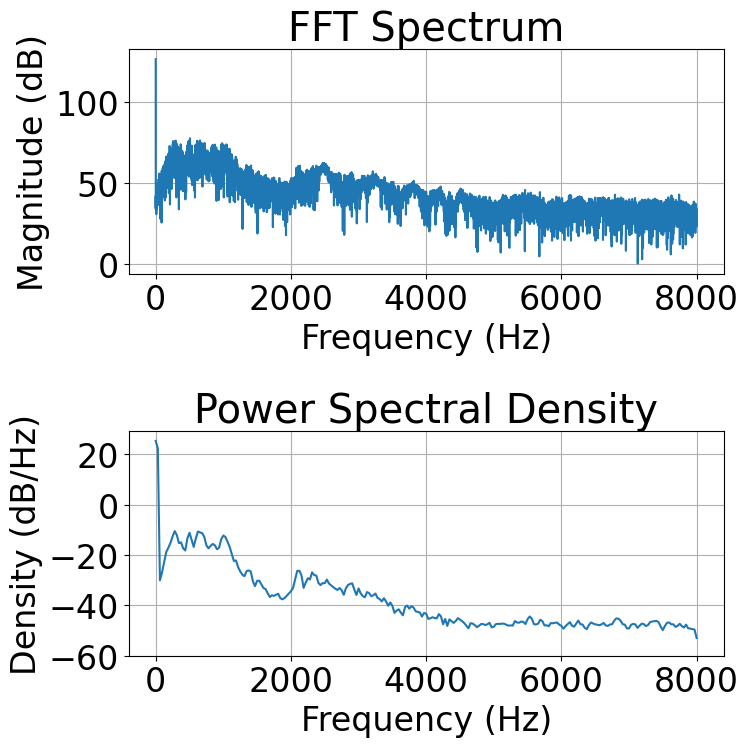

In [16]:
audio_spectrum = np.fft.rfft(segment_audio)
freqs = len(audio_spectrum)
audio_spectrum_mag = np.abs(audio_spectrum)
audio_spectrum_db =  20*np.log10(audio_spectrum_mag)

freq_axis = np.fft.rfftfreq(len(segment_audio), d=1/sample_rate)
fig, ax = plt.subplots(2,1,figsize=(8,8))

cur_ax = ax[0]
cur_ax.set_title(f'FFT Spectrum')
cur_ax.plot(freq_axis, audio_spectrum_db)
cur_ax.set_xlabel("Frequency (Hz)")
cur_ax.set_ylabel("Magnitude (dB)")
cur_ax.grid(which='both')

cur_ax = ax[1]
cur_ax.psd(segment_audio, NFFT=512, Fs=sample_rate, scale_by_freq=True)
cur_ax.set_title(f"Power Spectral Density")
cur_ax.set_yticks(np.arange(-60, 40, 20))
cur_ax.set_xlabel("Frequency (Hz)")
cur_ax.set_ylabel("Density (dB/Hz)")

fig.tight_layout()
plt.show()

In [17]:
def plot_audio_segment(start_time, duration, nfft):
    segment_duration = duration
    
    end_time = start_time + segment_duration
    start_idx = int(start_time * sample_rate)
    end_idx = int(end_time * sample_rate)
    segment_time = time_array[start_idx:end_idx]
    segment_audio = audio_data[start_idx:end_idx]
    vrms = get_rms_from_segment(segment_audio)
    db_spl = convertVtoSPL(vrms, reference_pressure=1e-6)

    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    plt.rcParams.update({'font.size':24})

    cur_ax = ax[0,0]
    cur_ax.plot(segment_time, segment_audio, label=r"$V_{\mathrm{rms}}$" + f'={vrms:.2f}V')
    cur_ax.set_xlim(start_time, end_time)
    cur_ax.set_title(f"Time-Series")
    cur_ax.set_ylabel('Voltage (V)')
    cur_ax.tick_params(axis='y', labelsize=plt.rcParams['font.size']-4)
    cur_ax.tick_params(axis='x', labelsize=plt.rcParams['font.size']-4)
    cur_ax.legend(loc='upper right', fontsize=12)

    cur_ax = ax[1,0]
    Pxx, freqs, bins, im = cur_ax.specgram(segment_audio, Fs=sample_rate, NFFT=nfft, cmap='jet', vmin=-60, vmax=0)
    cur_ax.set_title(f"Spectrogram")
    cur_ax.set_yticks(np.linspace(0, sample_rate/2, 5), (np.linspace(0, sample_rate/2, 5)).astype(int))
    cur_ax.set_xlim(0, segment_duration)
    cur_ax.set_ylabel('Frequency (Hz)')
    cur_ax.set_xlabel('Time (s)')

    legend_patch = patches.Patch(color='black', label=f"SPL={db_spl:.2f}dB SPL")  # Custom color
    cur_ax.legend(handles=[legend_patch], fontsize=12)
    cur_ax.tick_params(axis='y', labelsize=plt.rcParams['font.size']-4)
    cur_ax.tick_params(axis='x', labelsize=plt.rcParams['font.size']-4)

    audio_spectrum = np.fft.rfft(segment_audio)
    freqs = len(audio_spectrum)
    audio_spectrum_mag = np.abs(audio_spectrum)
    audio_spectrum_db =  20*np.log10(audio_spectrum_mag)

    freq_axis = np.fft.rfftfreq(len(segment_audio), d=1/sample_rate)
    cur_ax = ax[0,1]
    cur_ax.set_title(f'FFT Spectrum')
    cur_ax.plot(freq_axis, audio_spectrum_db)
    cur_ax.set_xlabel("Frequency (Hz)")
    cur_ax.set_ylabel("Magnitude (dB)")
    cur_ax.grid(which='both')

    cur_ax = ax[1,1]
    cur_ax.psd(segment_audio, NFFT=nfft, Fs=sample_rate, scale_by_freq=True)
    cur_ax.set_title(f"Power Spectral Density")
    cur_ax.set_yticks(np.arange(-60, 40, 20))
    cur_ax.set_xlabel("Frequency (Hz)")
    cur_ax.set_ylabel("Density (dB/Hz)")

    fig.tight_layout()

    time_series_xticks = ax[0,0].get_xticks()[ax[0,0].get_xticks()<=(end_time+1e-12)]
    ax[1,0].set_xticks(time_series_xticks - start_time, time_series_xticks.round(2))
    ax[1,0].set_xlim(0, segment_duration)

    plt.show()

In [18]:
start_slider = widgets.IntSlider(
    value=33,
    min=0,
    max=np.floor(audio_duration).astype(int),
    step=step_size,
    description="Start (s)",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

duration_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=np.ceil(audio_duration).astype(int),
    step=step_size,
    description="Duration (s)",
    continuous_update=False,
    style={'description_width': 'initial'} 
)


nfft_slider = widgets.IntSlider(
    value=256,
    min=256,
    max=2048,
    step=256,
    description="NFFT",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

widgets.interactive(plot_audio_segment, start_time=start_slider, duration=duration_slider, nfft=nfft_slider)

interactive(children=(IntSlider(value=33, continuous_update=False, description='Start (s)', max=59, style=Slid…